In [28]:
import time
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Kiểm tra sự cân bằng dữ liệu**

In [29]:
import os

base_dir = '/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train'
male_count = len(os.listdir(os.path.join(base_dir, 'Male')))
female_count = len(os.listdir(os.path.join(base_dir, 'Female')))
print(f"Train: male = {male_count}, female = {female_count}")



Train: male = 4000, female = 4000


## I. Chuẩn bị dữ liệu và label mapping
**1. Data Augmentation cho train**
+ Flip & Rotation:
    
      `RandomHorizontalFlip()`: giả lập ảnh chụp mirror, hữu ích khi định dạng khuôn mặt không phụ thuộc chiều.
    
      `RandomRotation(±15°)`: mô phỏng độ lệch góc chụp nhẹ, tăng khả năng nhận diện trong thực tế.
    
+ Color Jitter
    
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    
    ±20% thay đổi độ sáng, độ tương phản, độ bão hòa, ±10% thay đổi sắc độ.
    
    Giúp mô hình không phụ thuộc quá mức vào điều kiện ánh sáng hay tông màu.


+ RandomAffine
    
    translate=(0.1,0.1), scale=(0.9,1.1):
    
    Dịch chuyển tối đa 10% cả hai chiều, phóng to/thu nhỏ ±10%.
    
    Tăng tính bất biến với vị trí và kích thước khuôn mặt.
    
+ RandomErasing
    
    p=0.3, scale=(0.02,0.2):
    
    Xóa ngẫu nhiên 2–20% diện tích, xác suất 30%.
    
    Buộc mô hình học từ nhiều vùng thông tin khác nhau, giảm phụ thuộc vào các đặc trưng cố định như tóc hay khung mắt.

**2. Label mapping**
Mặc định ImageFolder gán label theo thứ tự alphabet: 'Female'→0, 'Male'→1. Tuy nhiên, yêu cầu bài toán là Male→0, Female→1. Vì vậy, em sử dụng Label mapping để ép nó về đúng với yêu cầu của đề

In [30]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),            # Chuyển sang Tensor trước khi RandomErasing
    transforms.RandomErasing(p=0.3),  # Áp dụng RandomErasing trên Tensor
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(root='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train', transform=train_transforms)
val_dataset   = datasets.ImageFolder(root='/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Val',   transform=val_transforms)

#Kiểm tra mapping ban đầu
print("Before:", train_dataset.class_to_idx)  

desired_mapping = {'Male': 0, 'Female': 1}
for ds in (train_dataset, val_dataset):
    #Gán lại class_to_idx
    ds.class_to_idx = desired_mapping

    #Cập nhật lại danh sách samples [(path, label), ...]
    new_samples = []
    for path, _ in ds.samples:
        cls_name = os.path.basename(os.path.dirname(path))
        new_label = desired_mapping[cls_name]
        new_samples.append((path, new_label))
    ds.samples = new_samples
    ds.classes = ['Male', 'Female']

    #Cập nhật targets (dùng cho loss/accuracy)
    ds.targets = [label for _, label in ds.samples]

print("After class_to_idx:", train_dataset.class_to_idx)
print("Classes list     :", train_dataset.classes)
print("Sample labels    :", train_dataset.samples[:5])
print("Targets           :", train_dataset.targets[:5])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)


Before: {'Female': 0, 'Male': 1}
After class_to_idx: {'Male': 0, 'Female': 1}
Classes list     : ['Male', 'Female']
Sample labels    : [('/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train/Female/000039.jpg', 1), ('/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train/Female/000057.jpg', 1), ('/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train/Female/000108.jpg', 1), ('/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train/Female/000148.jpg', 1), ('/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train/Female/000176.jpg', 1)]
Targets           : [1, 1, 1, 1, 1]


**2. Trực quan hóa một số phép Augmentation**:

a. **Chọn ngẫu nhiên 4 ảnh** (2 nam, 2 nữ) từ tập Train.  
b. **Hiển thị 3 cột với mỗi ảnh**  
   - **Cột 1 (Original):** Ảnh gốc được resize về 224×224 để đồng nhất kích thước.  
   - **Cột 2 (Flip):** Ảnh đã áp dụng phép Horizontal Flip, mô phỏng việc chụp mặt đối xứng.  
   - **Cột 3 (Flip + Brightness):** Từ ảnh flip, tăng độ sáng lên 30% bằng `ImageEnhance.Brightness`, giúp kiểm tra mô hình có thể kháng được thay đổi ánh sáng.

=> Kiểm tra trực quan rằng augmentation được áp dụng đúng cách và ảnh kết quả vẫn giữ được khuôn mặt rõ ràng. Đảm bảo mô hình sẽ được nhìn thấy nhiều phiên bản khác nhau của cùng một ảnh gốc


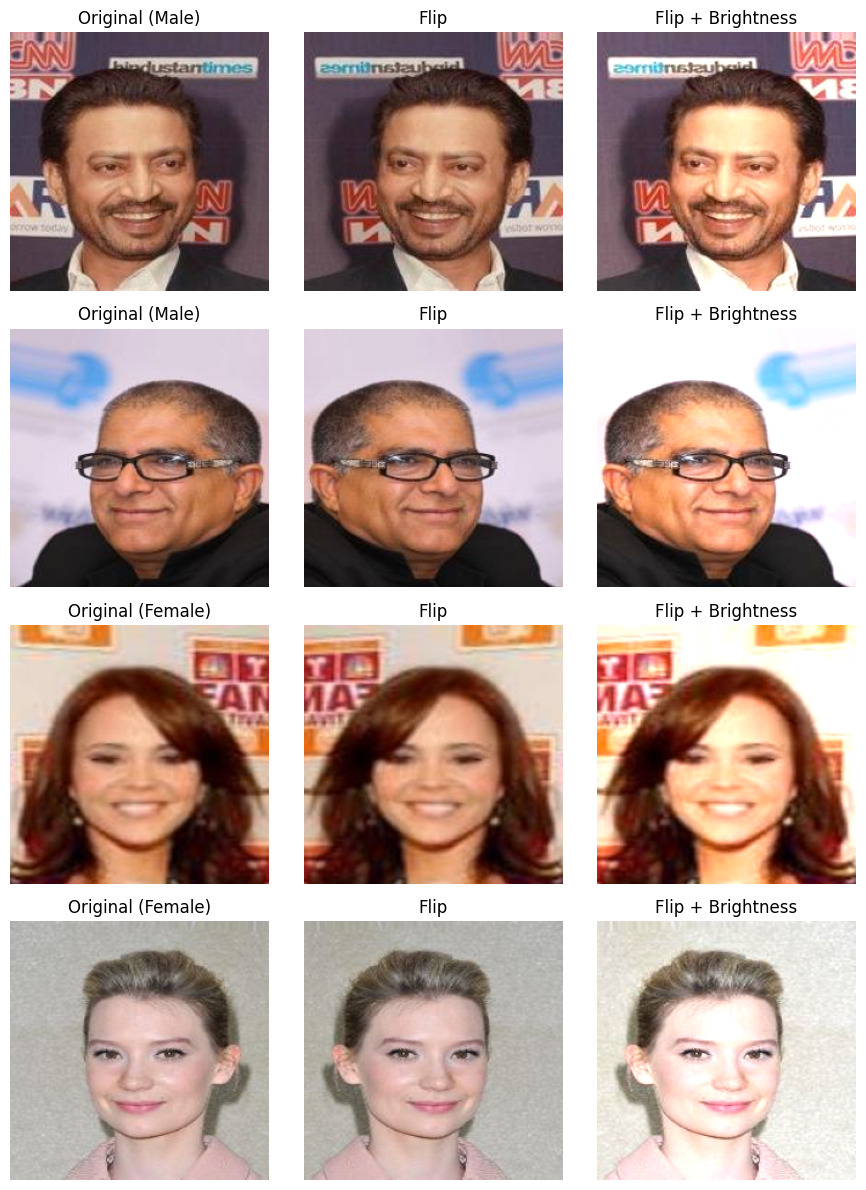

In [31]:
import os
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# 1. Cấu hình đường dẫn và lớp
train_dir = '/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train'
classes = ['Male', 'Female']

# 2. Lấy ngẫu nhiên 4 ảnh (2 male, 2 female)
samples = []
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    imgs = os.listdir(cls_dir)
    picks = random.sample(imgs, 2)
    for fn in picks:
        samples.append((os.path.join(cls_dir, fn), cls))

# 3. Tạo figure và hiển thị
fig, axes = plt.subplots(len(samples), 3, figsize=(9, 3*len(samples)))
for i, (path, cls) in enumerate(samples):
    img = Image.open(path).convert('RGB')
    
    # a) Original resized
    orig = img.resize((224,224))
    axes[i,0].imshow(orig)
    axes[i,0].set_title(f'Original ({cls})')
    axes[i,0].axis('off')
    
    # b) Horizonal flip
    flipped = orig.transpose(Image.FLIP_LEFT_RIGHT)
    axes[i,1].imshow(flipped)
    axes[i,1].set_title('Flip')
    axes[i,1].axis('off')
    
    # c) Brightness jitter
    enhancer = ImageEnhance.Brightness(flipped)
    jittered = enhancer.enhance(1.3)  # tăng độ sáng lên 30%
    axes[i,2].imshow(jittered)
    axes[i,2].set_title('Flip + Brightness')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

**3. Chuẩn bị Tập Test và Custom Dataset**
Vì tập test là bộ ảnh không có nhãn, em định nghĩa một lớp `TestDataset` kế thừa từ `torch.utils.data.Dataset`

In [32]:
import os
from PIL import Image
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        """
        test_dir: đường dẫn đến folder chứa ảnh test (chỉ ảnh, không có subfolder).
        transform: torchvision.transforms để áp dụng cho mỗi ảnh.
        """
        super(TestDataset, self).__init__()
        self.test_dir = test_dir
        self.transform = transform

        # Lấy danh sách tất cả file ảnh trong thư mục (lọc đuôi .jpg, .jpeg, .png)
        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
        # Sử dụng sorted() giúp thứ tự cố định
        self.image_names = sorted([
            fname for fname in os.listdir(test_dir)
            if fname.lower().endswith(valid_exts)
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Lấy tên file ở vị trí idx
        img_name = self.image_names[idx]
        img_path = os.path.join(self.test_dir, img_name)

        # Mở ảnh với PIL
        image = Image.open(img_path).convert('RGB')

        # Áp dụng transform (nếu có)
        if self.transform is not None:
            image = self.transform(image)

        # Trả về (image_tensor, image_name)
        return image, img_name
    

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [33]:
from torch.utils.data import DataLoader

test_dir = '/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Test'
test_dataset = TestDataset(test_dir=test_dir, transform=test_transforms)

# Dataloader: shuffle=False để giữ nguyên thứ tự image_names
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Số lượng ảnh trong test:", len(test_dataset))

Số lượng ảnh trong test: 1000


## II. Chuẩn bị mô hình


**1. SimpleCNN**

Em thiết kế một mô hình mạng nơ-ron tích chập (CNN) với kiến trúc tương đối đơn giản nhưng vẫn đảm bảo khả năng trích xuất đặc trưng tốt từ ảnh.

Cấu trúc mô hình gồm ba tầng Conv2D liên tiếp, mỗi tầng đi kèm với hàm kích hoạt ReLU và lớp MaxPooling2D nhằm giảm kích thước ảnh dần dần và giữ lại những đặc trưng quan trọng. Sau khối trích xuất đặc trưng, ảnh đầu vào được đưa vào khối phân loại với cấu trúc Flatten -> Linear -> ReLU -> Dropout -> Linear.

Ở tầng đầu ra, em sử dụng Linear(256, 2) và dùng sigmoid. Điều này giúp mô hình xuất ra 2 giá trị logit ứng với hai lớp giới tính (nam và nữ), sau đó được tính toán thông qua hàm CrossEntropyLoss.

Ngoài ra, em sử dụng bộ tối ưu Adam với tốc độ học là 0.001, kết hợp với scheduler ReduceLROnPlateau để điều chỉnh learning rate khi độ lỗi dừng cải thiện.
- Kết quả sau khi sử dụng mạng simpleCNN
  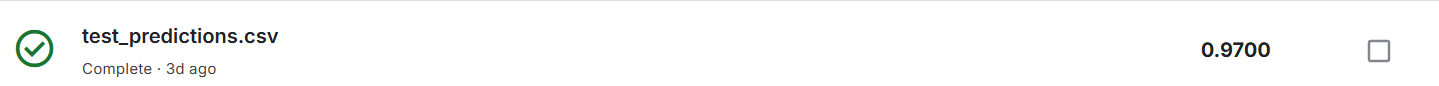

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size//8) * (img_size//8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            # thay 1 neuron thành 2 neurons, bỏ Sigmoid
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # logits shape [B,2]


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
model_simpleCNN = SimpleCNN().to(device)

criterion_simple_cnn = nn.CrossEntropyLoss()
optimizer_simple_cnn = torch.optim.Adam(model_simpleCNN.parameters(), lr=1e-3)
scheduler_simple_cnn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_simple_cnn, 
                                                     mode='min', 
                                                     factor=0.5, 
                                                     patience=5)

**2. efficientnetB0**

Bên cạnh việc tự xây dựng một mô hình CNN đơn giản, em cũng thử áp dụng transfer learning bằng cách sử dụng mô hình EfficientNet-B0 được huấn luyện sẵn trên tập ImageNet. Việc tận dụng một mô hình mạnh như EfficientNet giúp tiết kiệm thời gian huấn luyện và có thể cải thiện độ chính xác khi bài toán có số lượng dữ liệu vừa phải.
Trong phần này, em thực hiện các bước sau:

- Tải mô hình EfficientNet-B0 pretrained từ torchvision.models.

- Thay đổi lớp phân loại cuối từ Linear(1792 → 1000) thành Linear(1792 → 2) để phù hợp với bài toán phân loại 2 lớp (nam / nữ).

- Đóng băng phần trích xuất đặc trưng (feature extractor) tạm thời để chỉ huấn luyện phần classifier, giúp mô hình học nhanh và tránh overfitting khi dữ liệu không quá lớn.

- Khởi tạo hàm mất mát, bộ tối ưu, và scheduler, tương tự như mô hình CNN tự xây dựng. Ở đây em chỉ cập nhật các tham số chưa bị đóng băng (requires_grad=True).

- Việc sử dụng ReduceLROnPlateau vẫn được giữ lại để tự động điều chỉnh learning rate nếu model không tiến bộ sau một vài epoch.

- 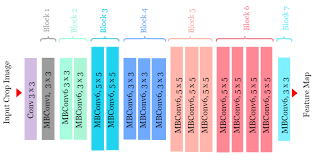

- Kết quả sau khi sử dụng model Pre-train efficientnetB0

- 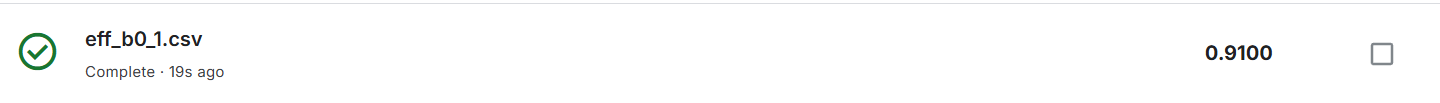
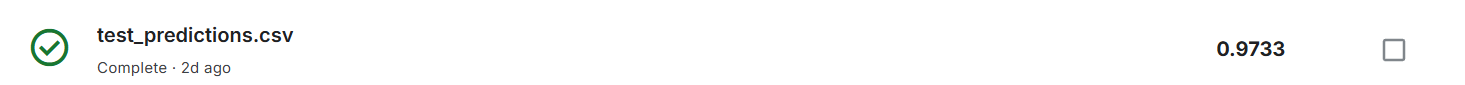
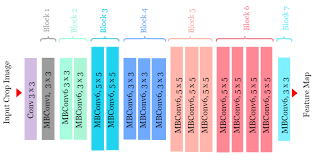
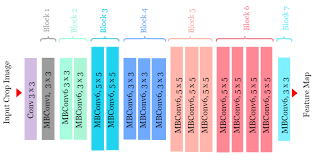
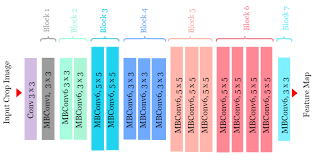

In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
model_eff_b0 = models.efficientnet_b0(pretrained=True)

# 2. Thay classifier cuối để output 2 classes
#    original classifier: [Dropout, Linear(1792→1000)]
in_features = model_eff_b0.classifier[1].in_features
model_eff_b0.classifier[1] = nn.Linear(in_features, 2)

# 3. (Tùy chọn) Freeze tạm thời feature extractor
for param in model_eff_b0.features.parameters():
    param.requires_grad = False

# 4. Đưa model lên GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eff_b0 = model_eff_b0.to(device)

# 5. Định nghĩa loss, optimizer, scheduler
criterion_eff_b0 = nn.CrossEntropyLoss()
# Chỉ train classifier lúc đầu
optimizer_eff_b0 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_eff_b0.parameters()), 
    lr=1e-3
)
scheduler_eff_b0 = ReduceLROnPlateau(optimizer_eff_b0, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**3. Resnet18**

- Ở bước tiếp theo, em thử nghiệm thêm một mô hình phổ biến khác là ResNet-18 để so sánh với các kiến trúc trước đó. ResNet là một trong những kiến trúc backbone mạnh mẽ và khá nhẹ, phù hợp với bài toán phân loại hai lớp như trong đề tài.
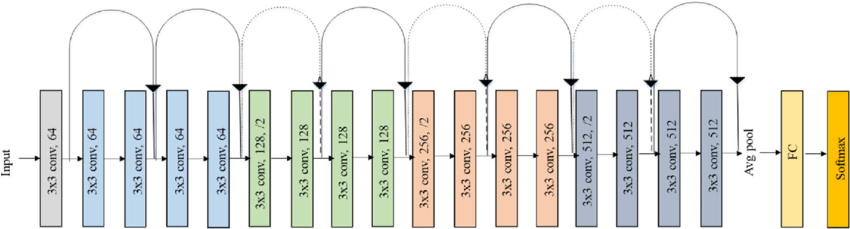
- Ban đầu, em sử dụng optimizer Adam kết hợp với scheduler ReduceLROnPlateau. Tuy nhiên, sau nhiều lần thử nghiệm, mô hình thường nhanh chóng rơi vào trạng thái "plateau" (val_loss không giảm), learning rate bị giảm sớm dẫn đến việc học chậm và độ chính xác không được cải thiện rõ rệt. Vì vậy, em quyết định thay đổi chiến lược huấn luyện.
- Các thay đổi
    - Optimizer: chuyển sang AdamW, một biến thể của Adam có thêm regularization thông qua weight decay. Điều này giúp hạn chế overfitting, đặc biệt khi fine-tune chỉ một phần mô hình.
    
    - Scheduler: thay vì giảm LR thủ công khi plateau, em sử dụng OneCycleLR – một chiến lược điều chỉnh learning rate theo chu kỳ. Learning rate ban đầu được tăng nhanh để mô hình thoát khỏi local minima, sau đó giảm dần theo cosine để mô hình hội tụ ổn định hơn.

+ Sử dụng Optimizer Adam và scheduler = ReduceLROnPlateau
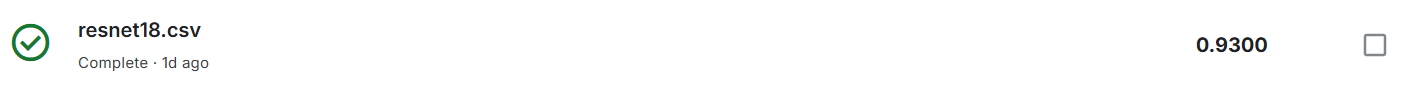
+ Sau khi chuyển sang Optimizer AdamW và scheduler = OneCycleLR
+ 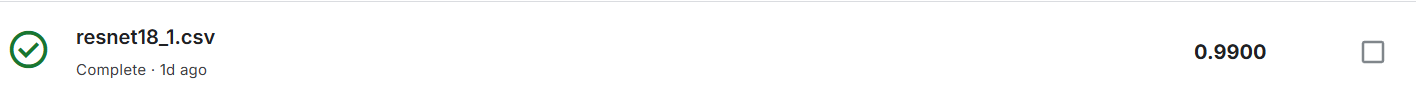
=> Sau khi chuyển sang cấu hình này, mô hình cho kết quả khả quan hơn rõ rệt so với cấu hình ban đầu.
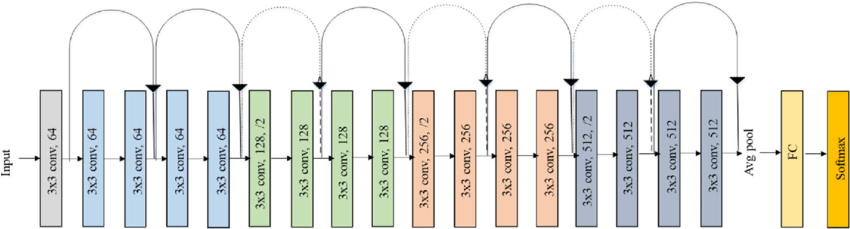

In [38]:
import torch
import torch.nn as nn
from torchvision import models

# --- 2. Model & Fine-tune ---
model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    if not any(x in name for x in ['layer3', 'layer4', 'fc']):
        param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
import torch.nn as nn
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.optim import AdamW

criterion_resnet18 = nn.CrossEntropyLoss(label_smoothing=0.1)
# Chỉ lấy những tham số có requires_grad=True (là fc)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

# optimizer = torch.optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-5)
optimizer_resnet18 = AdamW(
    trainable_params,
    lr=1e-3,            # max_lr cho OneCycle
    weight_decay=1e-4   # regularization
)

num_epochs = 50
steps_per_epoch = len(train_loader)
scheduler_resnet18 = OneCycleLR(
    optimizer_resnet18,
    max_lr=1e-3,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,         # phần tăng lr
    anneal_strategy='cos'  # Cosine annealing
)

# scheduler = ReduceLROnPlateau(optimizer,
#                               mode='min',       # ta muốn giảm val_loss
#                               factor=0.5,       # lr_new = lr_old * 0.5 khi plateau
#                               patience=3,       # chờ 3 epoch không giảm loss mới giảm lr
#                               verbose=True)     # in ra thông báo khi giảm lr
print("Model, criterion, optimizer, scheduler đã sẵn sàng.")

Model, criterion, optimizer, scheduler đã sẵn sàng.


## III. Trainging Loop

In [43]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model_with_earlystop(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device,
    num_epochs=50, checkpoint_path='model.pth', patience=10
):
    """
    Thêm early stopping: dừng khi val_loss không cải thiện sau `patience` epoch.
    """
    best_val_loss = float('inf')
    best_epoch = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # --- Train ---
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)

        train_loss = running_loss / total
        train_acc  = running_corrects / total

        # --- Validation ---
        model.eval()
        running_loss, running_corrects, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, dim=1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()
                total += inputs.size(0)
        val_loss = running_loss / total
        val_acc  = running_corrects / total

        # --- Scheduler ---
        if scheduler is not None:
            scheduler.step(val_loss)

        # --- Early stopping check ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), checkpoint_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        elapsed = time.time() - start_time
        print(f"Epoch {epoch:03d}/{num_epochs}  "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  |  "
              f"Val: loss={val_loss:.4f}, acc={val_acc:.4f}  |  "
              f"Time: {elapsed:.1f}s")

        # save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if epochs_no_improve >= patience:
            print(f"\n>>> Early stopping at epoch {epoch}. "
                  f"No improvement in val_loss for {patience} epochs.")
            break

    # load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"\nLoaded best model from epoch {best_epoch} with val_loss={best_val_loss:.4f}")

    return history, best_epoch

def plot_training_history(history):
    """Vẽ loss và accuracy curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy curve')
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 001/50  Train: loss=0.3768, acc=0.8846  |  Val: loss=0.3082, acc=0.9350  |  Time: 90.9s
Epoch 002/50  Train: loss=0.3130, acc=0.9357  |  Val: loss=0.2720, acc=0.9620  |  Time: 90.5s
Epoch 003/50  Train: loss=0.3017, acc=0.9435  |  Val: loss=0.3060, acc=0.9380  |  Time: 91.5s
Epoch 004/50  Train: loss=0.2770, acc=0.9586  |  Val: loss=0.2657, acc=0.9670  |  Time: 91.6s
Epoch 005/50  Train: loss=0.2724, acc=0.9594  |  Val: loss=0.2611, acc=0.9690  |  Time: 94.2s
Epoch 006/50  Train: loss=0.2668, acc=0.9624  |  Val: loss=0.2614, acc=0.9750  |  Time: 92.1s
Epoch 007/50  Train: loss=0.2585, acc=0.9684  |  Val: loss=0.2649, acc=0.9670  |  Time: 92.3s
Epoch 008/50  Train: loss=0.2559, acc=0.9715  |  Val: loss=0.2529, acc=0.9710  |  Time: 92.1s
Epoch 009/50  Train: loss=0.2534, acc=0.9719  |  Val: loss=0.2540, acc=0.9700  |  Time: 90.9s
Epoch 010/50  Train: loss=0.2469, acc=0.9754  |  Val: loss=0.2509, acc=0.9760  |  Time: 91.9s
Epoch 011/50  Train: loss=0.2457, acc=0.9759  |  Val: loss=0

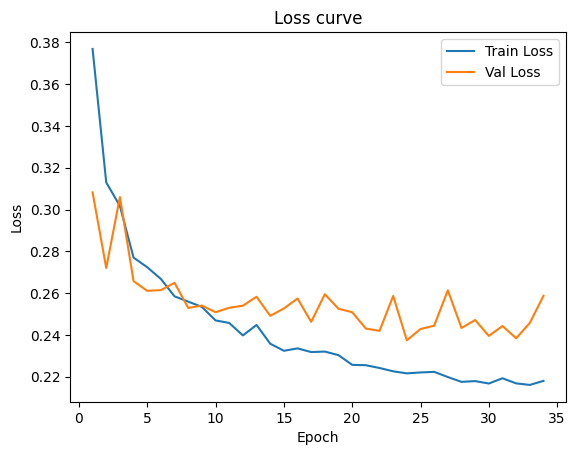

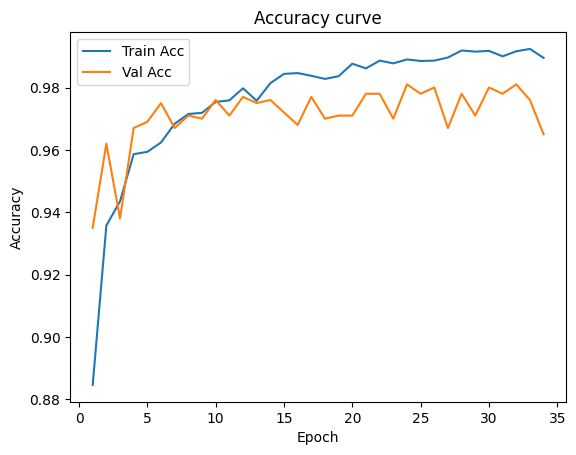

In [44]:
if __name__ == "__main__":
    num_epochs = 50
    # best_model_path = 'gender_model_resnet18_earlystop_2.pth'
    best_model_path = 'gender_model_resnet18_earlystop_1.pth'
    patience = 10  # dừng nếu val_loss không giảm trong 10 epoch

    history, best_epoch = train_model_with_earlystop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion_resnet18,
        optimizer=optimizer_resnet18,
        scheduler=scheduler_resnet18,
        device=device,
        num_epochs=num_epochs,
        checkpoint_path=best_model_path,
        patience=patience
    )

    # Vẽ đồ thị loss & accuracy
    plot_training_history(history)

## IV. Đánh giá mô hình

Sau khi hoàn tất quá trình huấn luyện, em tiến hành đánh giá mô hình (ở đây em chọn resnet18) trên tập validation để kiểm tra khả năng tổng quát hoá.


In [ ]:
# import torch
# import torch.nn as nn
# from sklearn.metrics import confusion_matrix, classification_report
# from torchvision import models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 2. Khởi tạo mô hình EfficientNet_B0
# model = models.efficientnet_b0(pretrained=True)

# # Lấy số đầu ra của lớp classifier gốc
# num_features = model.classifier[1].in_features

# # Thay thế lớp classifier để phân loại 2 lớp
# model.classifier[1] = nn.Linear(num_features, 2)

# # 3. Tải trọng số đã huấn luyện
# checkpoint_path = '/kaggle/working/gender_model_effb0_earlystop_1.pth'
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# model = model.to(device)
# model.eval()


In [45]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Khởi tạo kiến trúc model tương tự lúc training (ResNet-18 + fc→2)
from torchvision import models
model = models.resnet18(pretrained=False)     # pretrained=False để không load lại weights ImageNet
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# 3. Tải weights đã lưu
checkpoint_path = 'gender_model_resnet18_earlystop_1.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
all_preds = []
all_labels = []
all_probs = [] 

criterion = nn.CrossEntropyLoss()  # để tính loss trên mỗi batch

running_loss = 0.0
running_corrects = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)               # [B,2] logits
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)

        # Dự đoán class
        probs = torch.softmax(outputs, dim=1) # [B,2]
        _, preds = torch.max(probs, dim=1)    # [B]
        
        running_corrects += torch.sum(preds == labels).item()
        total_samples += inputs.size(0)

        # Thu thập để tính metric chi tiết
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())  # list of [p_female, p_male]

# Tính loss/acc trung bình
val_loss = running_loss / total_samples
val_acc = running_corrects / total_samples

print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")


Validation Loss: 0.0991 | Validation Acc: 0.9810


In [47]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

# Classification report (Precision, Recall, F1)
target_names = val_loader.dataset.classes  # ['female', 'male']
report = classification_report(all_labels, all_preds, target_names=target_names)
print("\nClassification Report:\n", report)


Confusion Matrix (rows=true, cols=pred):
 [[489  11]
 [  8 492]]

Classification Report:
               precision    recall  f1-score   support

        Male       0.98      0.98      0.98       500
      Female       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



## V. Lưu kết quả

In [48]:
import os
import torch
import csv

#model đang ở chế độ eval
model.eval()

results = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # lấy chỉ số class có xác suất cao nhất

        for filename, pred in zip(filenames, preds):
            # Tách phần ID, bỏ '.jpg'
            img_id = os.path.splitext(filename)[0]  
            results.append([img_id, int(pred)])     # Lưu [ID, Label]

# Ghi kết quả ra file CSV
with open("resnet18_1.csv", mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'Label'])  # header
    writer.writerows(results)

print("Dự đoán đã được lưu trong file resnet18_1.csv")


Dự đoán đã được lưu trong file resnet18_1.csv
